# Bayesian Multilevel Modelling using PyStan

This is a tutorial, following through Chris Fonnesbeck's [primer on using PyStan with Bayesian Multilevel Modelling](http://mc-stan.org/documentation/case-studies/radon.html).

# 7. Partial Pooling - Introduction

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import seaborn as sns

import clean_data
import unpooled_model

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Pooling and Multilevel/Hierarchical Models

### pooled model

When we *pool* data, we imply that they are sampled from the same model. This ignores all variation (other than sampling variation) among the units being sampled. That is to say, observations $y_1, y_2, \ldots, y_k$ share common parameter(s) $\theta$:

![pooled model](images/pooled_model.png)

### unpooled model

If we analyse our data with an *unpooled* model, we separate our data out into groups (which may be as extreme as one group per sample), which implies that the groups are sampled independently from separate models because the differences between sampling units are too great for them to be reasonably combined. That is to say, observations (or grouped observations) $y_1, y_2, \ldots, y_k$ have independent parameters $\theta_1, \theta_2, \ldots, \theta_k$.

![unpooled model](images/unpooled_model.png)

### partial pooling/hierarchical modelling

In a *hierarchical*, or *partial pooling* model, model parameters are instead viewed as a sample from a population distribution of parameters, so the unpooled model parameters $\theta_1, \theta_2, \ldots, \theta_k$ can be sampled from a single distribution $N(\mu, \sigma^2)$.

![partial pooled model](images/partial_pooled_model.png)

One of the great advantages of Bayesian modelling (as opposed to linear regression modelling) is the relative ease with which one can specify multilevel models and fit them using Hamiltonian Monte Carlo.

## Partial Pooling

### A simple model

The simplest possible partial pooling model for the radon dataset is one that estimates radon levels, with no other predictors (i.e. ignoring the effect of floor). This is a compromise between pooled (mean of all counties) and unpooled (county-level means), and approximates a *weighted average* (by sample size) of unpooled county means, and the pooled mean:

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

* $\hat{\alpha}$ - partially-pooled estimate of radon level
* $n_j$ - number of samples in county $j$
* $\bar{y}_j$ - estimated mean for county $j$
* $\sigma_y^2$ - s.e. of $\bar{y}_j$, variability of the county mean
* $\bar{y}$ - pooled mean estimate for $\alpha$
* $\sigma_{\alpha}^2$ - s.e. of $\bar{y}$

### Specifying the model

We can define this in `stan`, specifying `data`, `parameters`, `transformed parameters` and `model` blocks. The model is built up as follows.

Our observed log(radon) measurements ($y$ approximate an intermediate transformed parameter $\hat{y}$, which is normally distributed with variance $\sigma_y^2$:

$$y \sim N(\hat{y}, \sigma_y^2)$$

The transformed variable $\hat{y}$ is the value of $\alpha$ associated with the county $i$ ($i=1,\ldots,N$) in which each household is found.

$$\hat{y} = {\alpha_1, \ldots, \alpha_N}$$

The value of $\alpha$ for each county $i$, is Normally distributed with mean $10\mu_{\alpha}$ and variance $\sigma_{\alpha}^2$. That is, there is a common mean and variance underlying each of the prevailing radon levels in each county.

$$\alpha_i \sim N(10\mu_{\alpha}, \sigma_{\alpha}^2), i = 1,\ldots,N$$

The value $\mu_{\alpha}$ is Normally distributed around 0, with unit variance:

$$\mu_{\alpha} \sim N(0, 1)$$

In `data`:
* `N` will be the number of samples (`int`)
* `county` will be a list of `N` values from 1-85, specifying the county index each measurement
* `y` will be a `vector` of log(radon) measurements, one per household/sample.

We define parameters:

* `a` (`vector`, one value per county), representing $\alpha$, the vector of prevailing radon levels for each county.
* `mu_a`, a `real` corresponding to $\mu_{alpha}$, the mean radon level underlying the distribution from which the county levels are drawn.
* `sigma_a` is $\sigma_{\alpha}$, the standard deviation of the radon level distribution underlying the county levels: variability of county means about the average.
* `sigma_y` is $\sigma_y$, the standard deviation of the measurement/sampling error: residual error of the observations.

In [2]:
partial_pooling = """
data {
  int<lower=0> N;
  int<lower=1,upper=85> county[N];
  vector[N] y;
}
parameters {
  vector[85] a;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
}
transformed parameters {
  vector[N] y_hat;
  for(i in 1:N)
    y_hat[i] <- a[county[i]];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(10 * mu_a, sigma_a);
  
  y ~ normal(y_hat, sigma_y);
}
"""

We map Python variables onto the model data (remembering to offset counts/indices by 1, as Stan counts from 1, not from 0):

In [3]:
partial_pool_data = {'N': len(clean_data.log_radon),
                     'county': clean_data.county + 1,
                     'y': clean_data.log_radon}

Finally, we fit the model, to estimate $\mu_{\alpha}$, and $\alpha_i, i=1,\ldots,N$:

In [4]:
partial_pool_fit = pystan.stan(model_code=partial_pooling,
                               data=partial_pool_data,
                               iter=1000, chains=2)

We're interested primarily in the county-level estimates of prevailing radon levels, so we obtain the sample estimates for `a`:

In [5]:
sample_trace = partial_pool_fit['a']  
means = sample_trace.mean(axis=0) # county-level estimates
sd = sample_trace.std(axis=0)
samples, counties = sample_trace.shape
n_county = clean_data.srrs_mn.groupby('county')['idnum'].count()  # number of samples from each county

We're going to compare the results from our partially-pooled model to the unpooled model from `05-unpooled_model.ipynb`.

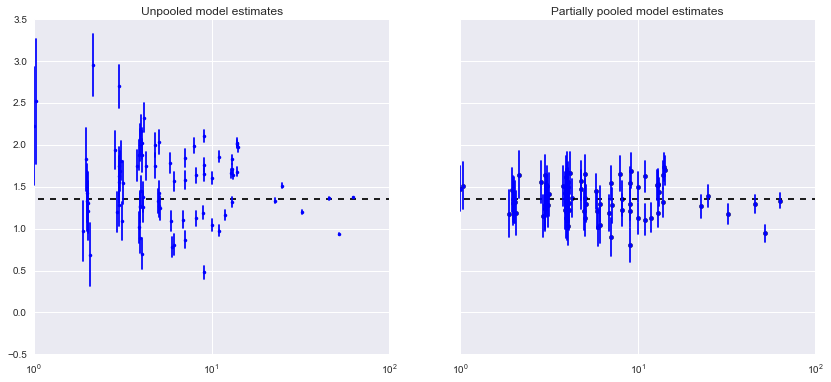

In [6]:
# Obtain unpooled estimates
unpooled = pd.DataFrame({'n': n_county,
                         'm': unpooled_model.unpooled_estimates,
                         'sd': unpooled_model.unpooled_se})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

# Construct axes for results
fig, axes = plt.subplots(1, 2, figsize=(14,6),
                         sharex=True, sharey=True)
jitter = np.random.normal(scale=0.1, size=counties)  # avoid overplotting counties

# Plot unpooled estimates
axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')  # means
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n + j, dat.n + j], [dat.m - dat.se, dat.m + dat.se], 'b-')

# Plot partially-pooled estimates
axes[1].scatter(n_county.values + jitter, means)
for j, n, m, s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n + j, n + j], [m - s, m + s], 'b-')

# Add line for underlying mean
for ax in axes:
    ax.hlines(sample_trace.mean(), 0.9, 100, linestyles='--')  # underlying mean from partial model

# Set axis limits/scale (shared x/y - need only to set one axis)
axes[0].set_xscale('log')
axes[0].set_xlim(1, 100)
axes[0].set_ylim(-0.5, 3.5)

# Set axis titles
axes[0].set_title("Unpooled model estimates")
axes[1].set_title("Partially pooled model estimates");

By inspection, there is quite a difference between unpooled and partially-pooled estimates of prevailing county-level radon level, especially as smaller sample sizes. The unpooled estimates at smaller sample sizes are both more extreme, and more imprecise.